# NLP workshop
## Imports and configurations 
 (db, global variables, gecko...)

In [ ]:
!python -m spacy download es_core_news_md

In [3]:
# Importing required libraries for web scrapping

import time
import datetime

from bs4 import BeautifulSoup
from selenium import webdriver

from pymongo import MongoClient

In [4]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from wordcloud import WordCloud

import spacy
from spacy import displacy
import en_core_web_sm

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import es_core_news_md
from nltk.tag import StanfordPOSTagger

import os

In [6]:
jar = "./pos-tagger/stanford-postagger/stanford-postagger-4.2.0.jar"
model = "./pos-tagger/stanford-postagger/models/spanish-ud.tagger"
os.environ["JAVAHOME"] = "/usr/bin/java"

In [7]:
# Creating a connection to MongoDB
client = MongoClient('localhost', 27017)
db = client['news-workshop']
collection = db['elespectador-workshop']

In [8]:
# Base URL of the site to be analyzed
SITE_URL = 'https://www.elespectador.com'

In [9]:
# Firefox web driver path
# Download the driver for you S.O. here: https://github.com/mozilla/geckodriver/releases
DRIVER_PATH = './geckodriver.exe'

## Webscraping

In [42]:
# Creating a new firefox window
browser = webdriver.Firefox(executable_path = DRIVER_PATH)

C:\Users\BORISL~1\AppData\Local\Temp/ipykernel_2424/1910320475.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Firefox(executable_path = DRIVER_PATH)


In [43]:
def make_request(browser, relative_path):
    # Making the request and rendering the browser
    browser.get(SITE_URL + relative_path)
    
    # Simulating vertical scrolling for handling lazy load
    check_height = browser.execute_script('return document.body.scrollHeight;')
    while True:
        browser.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        time.sleep(3)
        height = browser.execute_script('return document.body.scrollHeight;')
        if height == check_height: 
            break 
        check_height = height
    
    # Getting HTML content and passing it to BeautifulSoup for scraping analysis
    return BeautifulSoup(browser.page_source, 'html.parser')

In [10]:
categories = ['/archivo/politica/elecciones-colombia-2022/', '/archivo/tecnologia/', '/archivo/ambiente/', '/archivo/salud/', '/archivo/educacion/' ]

paginator = 1

news = []

In [48]:
for category in categories:
    # Getting HTML content for a particular news listing page
    wand = True
    
    while wand:
        page = "{}{}/".format(category, paginator)
        soup = make_request(browser, page)
    
        # Finding the section where news are contained 
        layout = soup.find(class_ = 'Layout-flexAds')
    
        # Getting blocks from layout
        blocks = layout.find_all(class_ = 'Container Block', recursive = True)
    
        # Finding and concatenating news cards
        cards = blocks[0].find_all(class_ = 'Card_rowCardLeft') + blocks[1].find_all(class_ = 'Card_rowCardLeft')
        
        for card in cards[:2]:
            date = card.find(class_ = 'Card-Datetime Datetime').get_text()
            
            x = datetime.datetime.now()- datetime.timedelta(weeks=2)
            months = ['feb.', 'mar.', 'apr.']
            partes = date.split(" ")
            if (partes[1]=='abr.'):
                partes[1] = 'apr.'
            elif(partes[1] not in months):
                partes[1] = 'apr.'
                partes[0] = datetime.datetime.now().day
                partes[2] = datetime.datetime.now().year
            fecha = "{}-{}-{}".format(partes[0], partes[1].replace(".",""), partes[2])
            date = datetime.datetime.strptime(fecha, '%d-%b-%Y')
            if date<x:
                wand = False
            
            # Getting HTML content for each news page
            r_path = card.find('h2', class_ = 'Card-Title').find('a')['href']
            soup = make_request(browser, r_path)
            
            author = ""
            paragraphs = soup.find_all(class_ = 'font--secondary')
            
            if soup.find(class_ = 'ACredit-Author').find('a'):
                author = soup.find(class_ = 'ACredit-Author').find('a').get_text()
            else:
                author = soup.find(class_ = 'ACredit-Author').get_text()
            
            categ = category.split("/")[2]
            
            news.append({
                'title': card.find('h2', class_ = 'Card-Title').find('a').get_text(),
                'relative_path': r_path,
                'datetime' : date,
                'author' : author,
                'summary' : soup.find(class_ = 'ArticleHeader-Hook').find('div').get_text(),
                'full_text' : ' '.join([p.get_text() for p in paragraphs]),
                'category' : categ,
            })
        
        paginator+=1
    
    paginator = 1
            

In [ ]:
news

In [49]:
# Storing extracted information for further analysis
collection.insert_many(news)

## NLP process

In [11]:
nlp = es_core_news_md.load()

### Process by categories
#### 1.Politics

In [12]:
text = []

for news in list(collection.find({"category" : "politica"}, {"title": 1, "summary": 1, "full_text": 1, "_id": 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])

text = " ".join(text)

In [14]:
# Stop words
# Stop words are basically a set of commonly used words in any language, not just English.
# The reason why stop words are critical to many applications is that, if we remove the words that are very commonly used in a given language, we can focus on the important words instead.

stop_words = set(stopwords.words("spanish"))

In [15]:
# Word tokenization
words = word_tokenize(text)

In [63]:
# Removing stop words
filtered_words = []
characters = [',','.','”','“',':',';','%','(',')','$']

for w in words:
    if w.lower() not in stop_words and w not in characters:
        filtered_words.append(w)

In [20]:
# Words distribution for text without stopwords
frec_dist_filtered = FreqDist(filtered_words)

In [ ]:
# Printing the most common words
frec_dist_filtered.most_common(15)

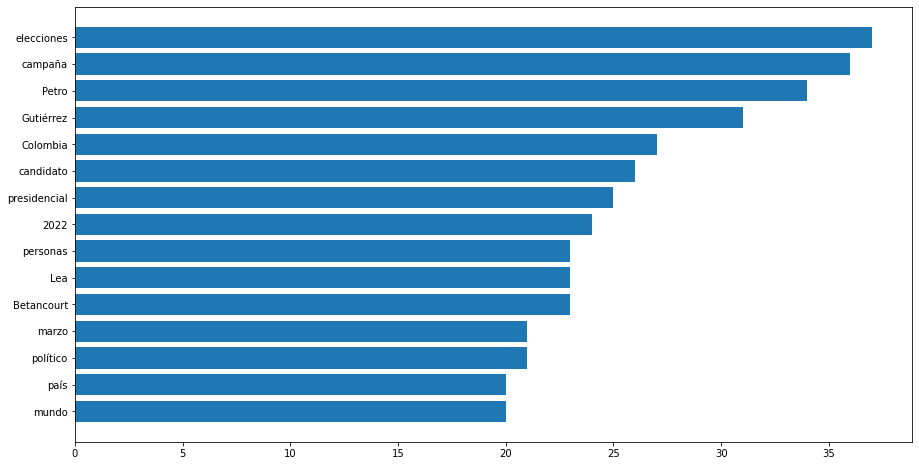

In [23]:
# Plotting a bar char for frecuencies
n = 15

plt.figure(figsize = (15, 8))
plt.barh([ w[0] for w in frec_dist_filtered.most_common(n) ], [ w[1] for w in frec_dist_filtered.most_common(n) ])
plt.gca().invert_yaxis()

In [ ]:
# Creating the wordcloud
# Word size is directly related to frecuency
filtered_text = " ".join(filtered_words)
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(filtered_text)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [27]:
# Part of Speech (PoS)
# The meaning of each tag can be found here: https://www.guru99.com/pos-tagging-chunking-nltk.html
pos_tags = nltk.pos_tag(filtered_words)

In [ ]:
# Sorting tags
pos_tags.sort(key = lambda tup: tup[1])

In [ ]:
# Named Entity Recognition (NER)
document = nlp(text)
displacy.render(document, style = "ent")

#### 2.Tecnology

In [15]:
text = []

for news in list(collection.find({"category" : "tecnologia"}, {"title": 1, "summary": 1, "full_text": 1, "_id": 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])

text = " ".join(text)

In [17]:
# Word tokenization
words = word_tokenize(text)

In [27]:
# Removing stop words
filtered_words = []

for w in words:
    if w.lower() not in stop_words and w not in characters:
        filtered_words.append(w)

In [28]:
# Words distribution for text without stopwords
frec_dist_filtered = FreqDist(filtered_words)

In [29]:
# Printing the most common words
frec_dist_filtered.most_common(15)

[('Apple', 43),
 ('millones', 24),
 ('empresa', 19),
 ('dólares', 14),
 ('US', 12),
 ('año', 12),
 ('Google', 12),
 ('Twitter', 11),
 ('niños', 10),
 ('puede', 10),
 ('mercado', 10),
 ('empresas', 10),
 ('aplicaciones', 10),
 ('digital', 9),
 ('años', 9)]

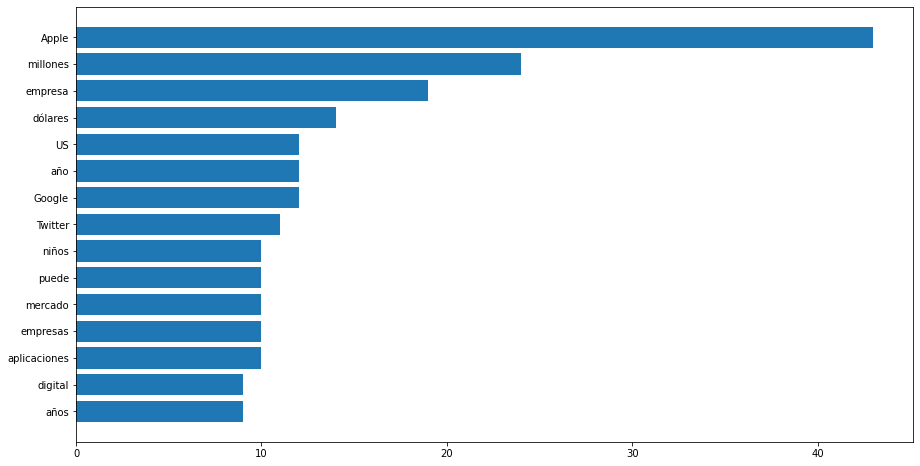

In [30]:
# Plotting a bar char for frecuencies
n = 15

plt.figure(figsize = (15, 8))
plt.barh([ w[0] for w in frec_dist_filtered.most_common(n) ], [ w[1] for w in frec_dist_filtered.most_common(n) ])
plt.gca().invert_yaxis()

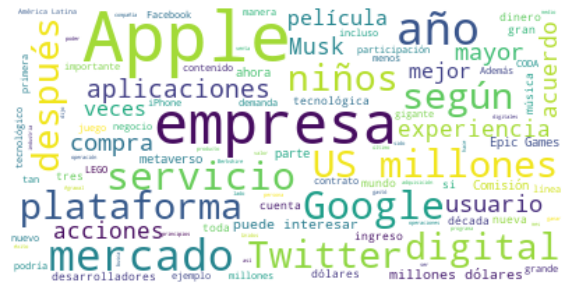

In [31]:
# Creating the wordcloud
# Word size is directly related to frecuency
filtered_text = " ".join(filtered_words)
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(filtered_text)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [32]:
# Part of Speech (PoS)
# The meaning of each tag can be found here: https://www.guru99.com/pos-tagging-chunking-nltk.html
pos_tags = nltk.pos_tag(filtered_words)

In [33]:
# Sorting tags
pos_tags.sort(key = lambda tup: tup[1])

In [ ]:
# Named Entity Recognition (NER)
document = nlp(text)
displacy.render(document, style = "ent")

#### 3.Environment

In [40]:
text = []

for news in list(collection.find({"category" : "ambiente"}, {"title": 1, "summary": 1, "full_text": 1, "_id": 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])

text = " ".join(text)

In [41]:
# Word tokenization
words = word_tokenize(text)

In [42]:
# Removing stop words
filtered_words = []

for w in words:
    if w.lower() not in stop_words and w not in characters:
        filtered_words.append(w)

In [43]:
# Words distribution for text without stopwords
frec_dist_filtered = FreqDist(filtered_words)

In [44]:
# Printing the most common words
frec_dist_filtered.most_common(15)

[('países', 38),
 ('Colombia', 23),
 ('residuos', 23),
 ('aves', 21),
 ('especies', 19),
 ('cambio', 18),
 ('riesgo', 18),
 ('país', 18),
 ('puede', 17),
 ('agua', 17),
 ('seguridad', 16),
 ('IPCC', 16),
 ('combustibles', 16),
 ('gran', 15),
 ('años', 15)]

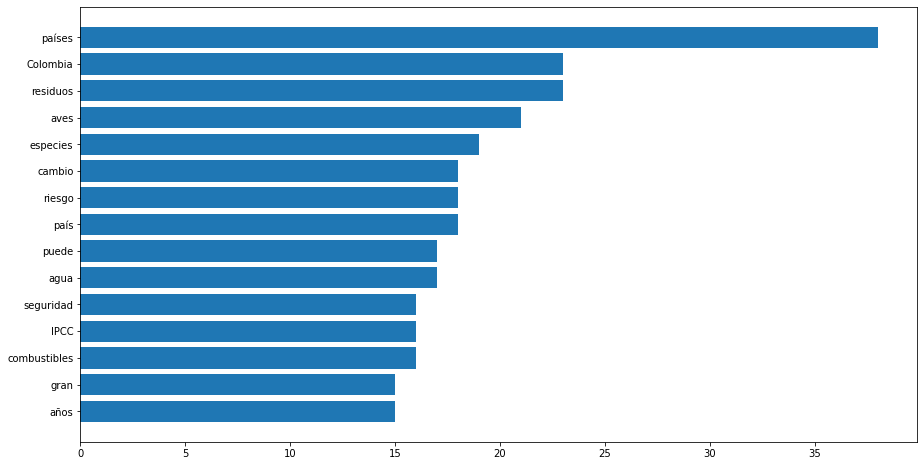

In [45]:
# Plotting a bar char for frecuencies
n = 15

plt.figure(figsize = (15, 8))
plt.barh([ w[0] for w in frec_dist_filtered.most_common(n) ], [ w[1] for w in frec_dist_filtered.most_common(n) ])
plt.gca().invert_yaxis()

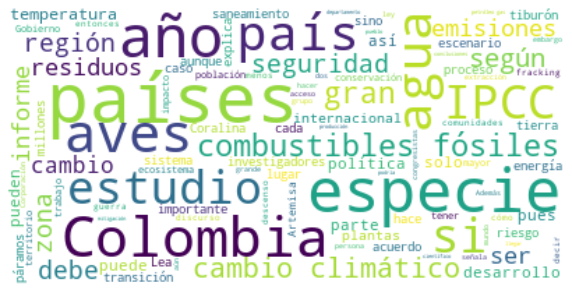

In [46]:
# Creating the wordcloud
# Word size is directly related to frecuency
filtered_text = " ".join(filtered_words)
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(filtered_text)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [47]:
# Part of Speech (PoS)
# The meaning of each tag can be found here: https://www.guru99.com/pos-tagging-chunking-nltk.html
pos_tags = nltk.pos_tag(filtered_words)

In [48]:
# Sorting tags
pos_tags.sort(key = lambda tup: tup[1])

In [ ]:
# Named Entity Recognition (NER)
document = nlp(text)
displacy.render(document, style = "ent")

#### 4.Health

In [49]:
text = []

for news in list(collection.find({"category" : "salud"}, {"title": 1, "summary": 1, "full_text": 1, "_id": 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])

text = " ".join(text)

In [50]:
# Word tokenization
words = word_tokenize(text)

In [51]:
# Removing stop words
filtered_words = []

for w in words:
    if w.lower() not in stop_words and w not in characters:
        filtered_words.append(w)

In [52]:
# Words distribution for text without stopwords
frec_dist_filtered = FreqDist(filtered_words)

In [53]:
# Printing the most common words
frec_dist_filtered.most_common(15)

[('OMS', 28),
 ('casos', 27),
 ('Wolbachia', 23),
 ('muertes', 21),
 ('país', 19),
 ('ver', 19),
 ('dengue', 19),
 ('personas', 18),
 ('Puede', 18),
 ('enfermedad', 18),
 ('Vélez', 18),
 ('Salud', 18),
 ('China', 17),
 ('millones', 17),
 ('2021', 17)]

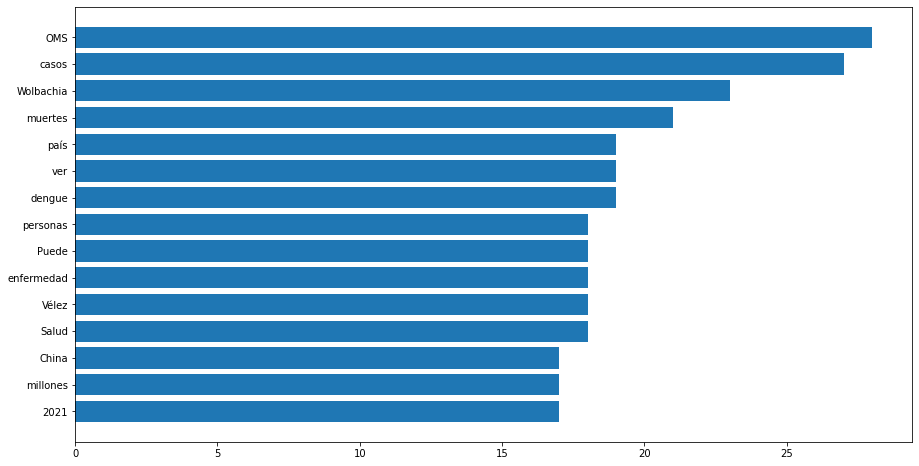

In [54]:
# Plotting a bar char for frecuencies
n = 15

plt.figure(figsize = (15, 8))
plt.barh([ w[0] for w in frec_dist_filtered.most_common(n) ], [ w[1] for w in frec_dist_filtered.most_common(n) ])
plt.gca().invert_yaxis()

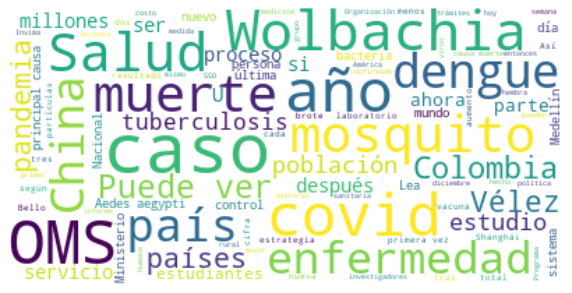

In [55]:
# Creating the wordcloud
# Word size is directly related to frecuency
filtered_text = " ".join(filtered_words)
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(filtered_text)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [56]:
# Part of Speech (PoS)
# The meaning of each tag can be found here: https://www.guru99.com/pos-tagging-chunking-nltk.html
pos_tags = nltk.pos_tag(filtered_words)

In [57]:
# Sorting tags
pos_tags.sort(key = lambda tup: tup[1])

In [ ]:
# Named Entity Recognition (NER)
document = nlp(text)
displacy.render(document, style = "ent")

#### 5.Education

In [58]:
text = []

for news in list(collection.find({"category" : "educacion"}, {"title": 1, "summary": 1, "full_text": 1, "_id": 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])

text = " ".join(text)

In [59]:
# Word tokenization
words = word_tokenize(text)

In [65]:
# Removing stop words
filtered_words = []

for w in words:
    if w.lower() not in stop_words and w not in characters:
        filtered_words.append(w)

In [66]:
# Words distribution for text without stopwords
frec_dist_filtered = FreqDist(filtered_words)

In [67]:
# Printing the most common words
frec_dist_filtered.most_common(15)

[('estudiantes', 23),
 ('Universidad', 22),
 ('educación', 13),
 ('U.', 13),
 ('niños', 12),
 ('programas', 11),
 ('Andes', 11),
 ('Bogotá', 10),
 ('obra', 10),
 ('Cruz-Diez', 10),
 ('universidad', 9),
 ('cada', 8),
 ('país', 7),
 ('100', 7),
 ('forma', 7)]

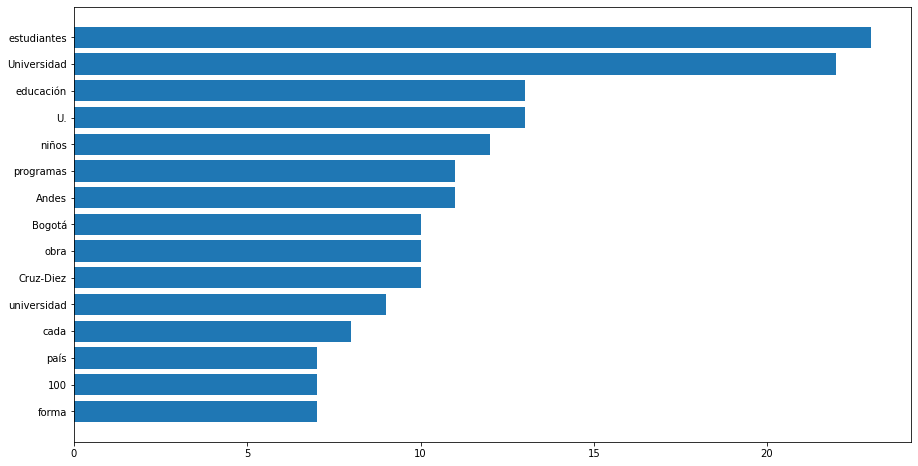

In [68]:
# Plotting a bar char for frecuencies
n = 15

plt.figure(figsize = (15, 8))
plt.barh([ w[0] for w in frec_dist_filtered.most_common(n) ], [ w[1] for w in frec_dist_filtered.most_common(n) ])
plt.gca().invert_yaxis()

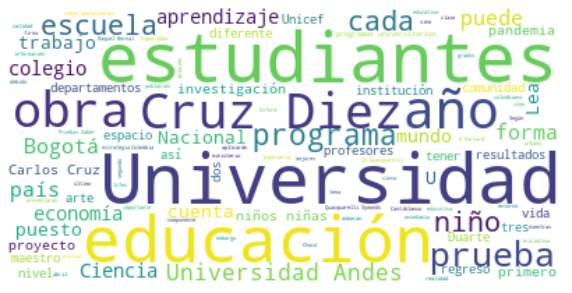

In [69]:
# Creating the wordcloud
# Word size is directly related to frecuency
filtered_text = " ".join(filtered_words)
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(filtered_text)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [70]:
# Part of Speech (PoS)
# The meaning of each tag can be found here: https://www.guru99.com/pos-tagging-chunking-nltk.html
pos_tags = nltk.pos_tag(filtered_words)

In [71]:
# Sorting tags
pos_tags.sort(key = lambda tup: tup[1])

In [ ]:
# Named Entity Recognition (NER)
document = nlp(text)
displacy.render(document, style = "ent")